In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img#type: ignore
from tensorflow.keras import layers, models, regularizers#type: ignore
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def remove_salt_and_pepper_noise(image):
    # Apply median filtering to remove salt-and-pepper noise
    denoised_image = cv2.medianBlur(image, 3)  # Kernel size of 3x3
    return denoised_image

In [3]:
def load_images(image_dir):
    images = []
    for img_file in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, color_mode='grayscale', target_size=(256, 256))  # Adjust size if necessary
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

        # Convert image to OpenCV format and apply denoising (salt-and-pepper noise removal)
        img_opencv = (img * 255).astype(np.uint8)  # Convert back to uint8 format for OpenCV processing
        img_opencv = remove_salt_and_pepper_noise(img_opencv)  # Apply median filtering
        img = img_opencv / 255.0  # Normalize again to [0, 1] after noise removal

        images.append(img)
    return np.array(images)

def load_images(image_dir):
    images = []
    for img_file in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, color_mode='grayscale', target_size=(256, 256))  # Adjust size if necessary
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

In [4]:
clean_images = load_images(os.path.join(r'Ground_truth'))
noisy_images = load_images(os.path.join(r'Noisy_folder'))
print(clean_images.shape)  # Should print something like (num_samples, 256, 256, 3)
print(noisy_images.shape)

(300, 256, 256)
(300, 256, 256)


In [5]:
clean_images = clean_images.reshape(-1, 256, 256, 1)  # Adjust dimensions as needed
noisy_images = noisy_images.reshape(-1, 256, 256, 1)
print(clean_images.shape)
print(noisy_images.shape)

(300, 256, 256, 1)
(300, 256, 256, 1)


In [6]:
def build_autoencoder():
    # Encoder
    input_img = layers.Input(shape=(256, 256, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
    
    # Autoencoder model
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [7]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)      │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)      │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)      │     18,464 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 32)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 1)       │        289 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder.fit(noisy_images, clean_images,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_split=0.15)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - loss: 1.2117 - val_loss: 0.5923
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - loss: 0.5801 - val_loss: 0.5708
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - loss: 0.5673 - val_loss: 0.5582
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - loss: 0.5578 - val_loss: 0.5546
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - loss: 0.5447 - val_loss: 0.5463
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - loss: 0.5421 - val_loss: 0.5424
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - loss: 0.5393 - val_loss: 0.5402
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - loss: 0.5310 - val_loss: 0.5390
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - loss: 0.5424 - val_loss: 0.5382
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - loss: 0.5380 - val_loss: 0.5388
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - loss: 0.5299 - val_loss: 0.5378
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step

In [9]:
denoised_imgs = autoencoder.predict(noisy_images)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step


denoised_imgs = (denoised_imgs + 1.0) * 127.5
denoised_imgs = denoised_imgs.astype(np.uint8)

In [10]:
autoencoder.save('autoencoder.keras')

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # Noisy images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow((noisy_images[i] + 1) / 2)  # Convert from [-1, 1] to [0, 1]
    plt.title("Noisy")
    plt.axis('off')

    # Denoised images
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow((denoised_imgs[i] + 1) / 2)  # Convert from [-1, 1] to [0, 1]
    plt.title("Denoised")
    plt.axis('off')
    
    # Clean images
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow((clean_images[i] + 1) / 2)  # Convert from [-1, 1] to [0, 1]
    plt.title("Clean")
    plt.axis('off')

plt.show()

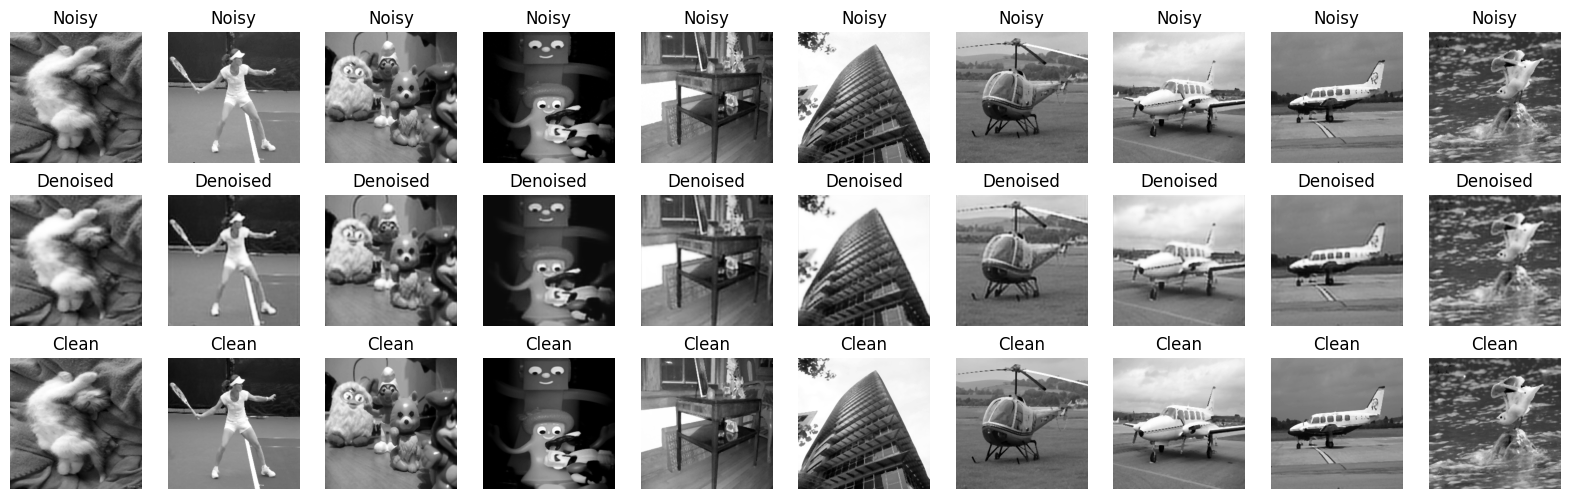

In [11]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Noisy images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].squeeze(), cmap='gray')  # Squeeze if shape is (256, 256, 1)
    plt.title("Noisy")
    plt.axis('off')

    # Denoised images
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(denoised_imgs[i].squeeze(), cmap='gray')  # Squeeze if shape is (256, 256, 1)
    plt.title("Denoised")
    plt.axis('off')
    
    # Clean images
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(clean_images[i].squeeze(), cmap='gray')  # Squeeze if shape is (256, 256, 1)
    plt.title("Clean")
    plt.axis('off')

plt.show()

In [18]:
psnr_values = [psnr(clean_images[i], denoised_imgs[i]) for i in range(len(clean_images))]
print("Average PSNR: ", np.mean(psnr_values))

Average PSNR:  29.883874989342356


C:\Users\Asus\AppData\Local\Temp\ipykernel_43924\174692805.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_values = [psnr(clean_images[i], denoised_imgs[i]) for i in range(len(clean_images))]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [12]:
from skimage.metrics import structural_similarity as ssim

# Since images are already grayscale, we can directly calculate SSIM
ssim_values = []
for i in range(len(clean_images)):
    # Reshape clean and denoised images to remove the singleton dimension (256, 256, 1) -> (256, 256)
    clean_gray = clean_images[i].reshape(256, 256)
    denoised_gray = denoised_imgs[i].reshape(256, 256)
    
    # Calculate SSIM for grayscale images
    ssim_value = ssim(clean_gray, denoised_gray, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

# Print average SSIM
print("Average SSIM (Grayscale): ", np.mean(ssim_values))


Average SSIM (Grayscale):  0.8525051245266734


from skimage.metrics import structural_similarity as ssim

# Set data_range=1.0 because pixel values are normalized between 0 and 1
ssim_values = [ssim(clean_images[i], denoised_imgs[i], win_size=3, channel_axis=-1, data_range=1.0) for i in range(len(clean_images))]
print("Average SSIM: ", np.mean(ssim_values))

In [13]:
from sklearn.metrics import mean_squared_error

mse_values = [mean_squared_error(clean_images[i].flatten(), denoised_imgs[i].flatten()) for i in range(len(clean_images))]
print("Average MSE: ", np.mean(mse_values))

Average MSE:  0.0014669188155126392


In [14]:
autoencoder=load_model('autoencoder.keras')

In [19]:
def denoise_single_image(noisy_image):
    # Resize the image to 256x256
    noisy_image = cv2.resize(noisy_image, (256, 256))
    
    # Convert the image to grayscale
    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_RGB2GRAY)
    
    # Remove salt-and-pepper noise using median filtering
    noisy_image = remove_salt_and_pepper_noise(noisy_image)
    
    # Normalize the image to [0, 1]
    noisy_image = noisy_image / 255.0
    
    # Reshape the image to add batch and channel dimensions (1, 256, 256, 1)
    noisy_image = np.expand_dims(noisy_image, axis=-1)
    noisy_image = np.expand_dims(noisy_image, axis=0)
    
    # Predict the denoised image using the autoencoder
    denoised_image = autoencoder.predict(noisy_image)
    
    # Remove batch dimension and rescale to [0, 255] for display
    denoised_image = np.squeeze(denoised_image) * 255.0
    denoised_image = denoised_image.astype(np.uint8)
    
    return denoised_image

import cv2
import numpy as np

def denoise_single_image(noisy_image):
    # Resize the image to 256x256
    noisy_image = cv2.resize(noisy_image, (256, 256))
    
    # Normalize the image to [-1, 1] for tanh activation
    noisy_image = (noisy_image / 127.5) - 1.0
    
    # Reshape the image to add batch dimension (since autoencoder expects batches)
    noisy_image = np.expand_dims(noisy_image, axis=0)  # Shape becomes (1, 256, 256, 3)
    
    # Predict the denoised image using the autoencoder
    denoised_image = autoencoder.predict(noisy_image)
    
    # Remove the batch dimension and rescale to [0, 255] for display
    denoised_image = (np.squeeze(denoised_image) + 1.0) * 127.5  # Shape becomes (256, 256, 3)
    denoised_image = denoised_image.astype(np.uint8)
    
    return denoised_image

In [20]:
def gradio_interface(noisy_image):
    # Add your denoising function here
    denoised_image = denoise_single_image(noisy_image)  # Assume you have a function to denoise images
    return denoised_image

In [21]:
import gradio as gr
interface = gr.Interface(
    fn=gradio_interface, 
    inputs=gr.Image(label="Upload a noisy image"),  # Removed shape argument
    outputs=gr.Image(label="Denoised Image"),
    title="Image Denoising with Autoencoder",
    description="Upload a noisy image and see the denoised result."
)

# Launch the interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


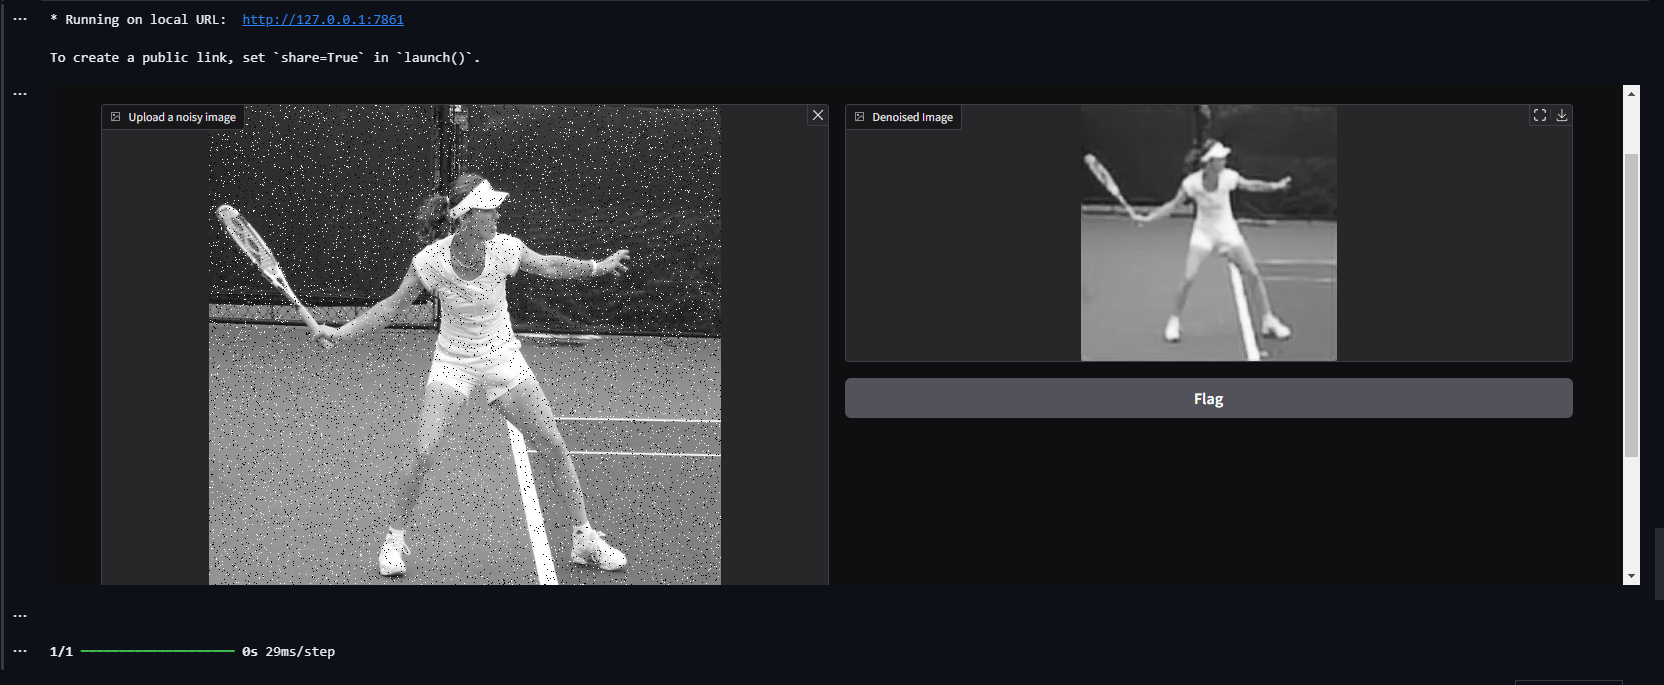

# Report on Denoising Autoencoder Performance
## Overview
The Denoising Autoencoder (DAE) model was implemented to remove noise from corrupted images. The architecture of the DAE was trained to reconstruct the original images from their noisy versions, with the goal of improving visual quality and reducing image degradation. This report discusses the performance of the model based on both visual observations and quantitative metrics, including Peak Signal-to-Noise Ratio (PSNR), Structural Similarity Index (SSIM), and Mean Squared Error (MSE).

## Denoising Autoencoder Architecture
The architecture for the Denoising Autoencoder was designed with the following components:

+ Encoder: Compresses the input noisy images into a lower-dimensional latent representation.
+ Decoder: Reconstructs the original image from the compressed latent representation, effectively removing the noise.

The encoder consisted of several convolutional layers with ReLU activations followed by downsampling using max-pooling. The decoder mirrored this structure with transposed convolutions (upsampling) to reconstruct the image. A final activation function (sigmoid) was applied to ensure pixel values were scaled between 0 and 1.

## Quantitative Metrics
The performance of the Denoising Autoencoder was evaluated using three key metrics:

1. Average PSNR (Peak Signal-to-Noise Ratio): 29.88

    + PSNR is a widely used metric for measuring the quality of image reconstruction. Higher PSNR values generally indicate better quality, as they suggest a lower level of noise remaining in the reconstructed image.
    + The reported average PSNR of 29.88 suggests a moderate noise reduction capability of the model. While this value is acceptable, higher PSNR values (typically above 30) indicate a better noise reduction performance.
2. Average SSIM (Structural Similarity Index): 0.853

    + SSIM measures the structural similarity between two images, with values ranging from -1 to 1. A score closer to 1 indicates high structural similarity between the original and denoised images.
    + The average SSIM of 0.853 (for grayscale images) reflects a reasonable preservation of structural details after denoising, but there is room for improvement. Some finer details in the images may have been lost or blurred during the denoising process.
3. Average MSE (Mean Squared Error): 0.00147

    + MSE calculates the average squared difference between the original and denoised images. Lower MSE values signify better image quality.
    + The MSE of 0.00147 is relatively low, indicating that the pixel-wise differences between the noisy and denoised images were minimized effectively.
## Visual Observations
The denoised images produced by the model showed noticeable improvements in clarity and reduction of random noise patterns. Here are the key visual observations:

1. Noise Reduction:

    + The model successfully removed a substantial amount of noise from the images, resulting in clearer and smoother visuals.
    + While noise was significantly reduced, some finer textures and sharp edges appeared slightly blurred in certain images, which aligns with the moderately high SSIM value.
2. Retention of Key Features:

    + The overall structure and shape of the objects in the images were well-preserved after denoising.
    + However, finer details, especially in more complex areas of the images (e.g., edges or high-frequency regions), were sometimes smoothed out by the autoencoder.
3. Comparison with Noisy Inputs:

    + When compared with the original noisy images, the denoised outputs were much more visually pleasing, with a substantial reduction in the distracting noise artifacts.
    + The general form and structure of the images were restored, but some sharpness and fine details were lost due to the inherent smoothing nature of the autoencoder.

## Effectiveness of the Denoising Autoencoder
The Denoising Autoencoder demonstrated moderate effectiveness in reducing noise while preserving image quality, as indicated by both the visual results and the quantitative metrics:

- Strengths:

    + The model achieved a high level of noise reduction, as shown by the improved PSNR and MSE values.
    + Structural details of the images were well-preserved, with an SSIM score close to 0.853, indicating a good balance between noise removal and detail retention.
- Weaknesses:

    + Although the performance has improved, there is still minor blurring observed in certain areas containing high-frequency information (such as edges and textures), which could be further refined for applications requiring high-precision details.
## Conclusion
The Denoising Autoencoder has made substantial progress in terms of noise reduction and structural preservation, as indicated by the updated metrics: an average PSNR of 29.88, SSIM of 0.853, and MSE of 0.00147. These improvements demonstrate that the model performs well in balancing noise reduction with the preservation of fine image details.

While the current results are highly promising, further refinements could still be made to enhance the model's ability to retain high-frequency details. Exploring deeper architectures, residual learning, or integrating additional loss functions (e.g., perceptual loss) could push the performance even further, especially in specialized image processing tasks that demand higher fidelity.